# Brazilian air transportation network analysis

## Dependencies

In [3]:
!pip install geopandas

     |████████████████████████████████| 994 kB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 


In [4]:
import pandas as pd
import numpy as np
import networkx as nx
# import nxviz
# from nxviz import GeoPlot
# from nxviz.plots import CircosPlot
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import seaborn as sns
import geopandas as gpd

In [5]:
!wget -O gbr.rar https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/gbr.rar

!unrar x "gbr.rar" "gbr"

ibge_data = gpd.read_file("gbr")

--2021-08-09 01:34:38--  https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/gbr.rar
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/main/data/gbr.rar [following]
--2021-08-09 01:34:38--  https://raw.githubusercontent.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/main/data/gbr.rar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11182115 (11M) [application/octet-stream]
Saving to: ‘gbr.rar’

gbr.rar             100%[===================>]  10.66M  30.1MB/s    in 0.4s    

2021-08-09 01:34:40 (30.1 MB/

In [6]:
flights21 = pd.read_csv('https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/brazilian_flights_data_2021.csv', sep=';', encoding='latin-1')
flights20 = pd.read_csv('https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/brazilian_flights_data_2020.csv', sep=';', encoding='latin-1')
flights19 = pd.read_csv('https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/brazilian_flights_data_2019.csv', sep=';', encoding='latin-1')
airport_location = pd.read_csv('https://github.com/matheusmas132/Brazilian-Air-Traffic-Network-Analysis/raw/main/data/airport-codes_csv.csv')

In [7]:
flights21.head(1)

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MÊS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIÃO),AEROPORTO DE ORIGEM (PAÍS),AEROPORTO DE ORIGEM (CONTINENTE),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE DESTINO (REGIÃO),AEROPORTO DE DESTINO (PAÍS),AEROPORTO DE DESTINO (CONTINENTE),NATUREZA,GRUPO DE VOO,PASSAGEIROS PAGOS,PASSAGEIROS GRÁTIS,CARGA PAGA (KG),CARGA GRÁTIS (KG),CORREIO (KG),ASK,RPK,ATK,RTK,COMBUSTÍVEL (LITROS),DISTÂNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2021,1,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGR,GUARULHOS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,1609.0,125.0,280591.0,0.0,68866.0,72835700.0,13264600.0,11500400.0,4074720.0,0.0,255564.0,31.0,2.313190e+09,0.0,567731000.0,8835.0,1395000.0,"309,584",0.0


In [8]:
flights20.head(1)

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MÊS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIÃO),AEROPORTO DE ORIGEM (PAÍS),AEROPORTO DE ORIGEM (CONTINENTE),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE DESTINO (REGIÃO),AEROPORTO DE DESTINO (PAÍS),AEROPORTO DE DESTINO (CONTINENTE),NATUREZA,GRUPO DE VOO,PASSAGEIROS PAGOS,PASSAGEIROS GRÁTIS,CARGA PAGA (KG),CARGA GRÁTIS (KG),CORREIO (KG),ASK,RPK,ATK,RTK,COMBUSTÍVEL (LITROS),DISTÂNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,AAL,"AMERICAN AIRLINES, INC.",ESTRANGEIRA,2020,1,KDFW,"DALLAS & FORT WORTH, TEXAS",NaN,NaN,ESTADOS UNIDOS DA AMÉRICA,AMÉRICA DO NORTE,SBGL,RIO DE JANEIRO,RJ,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,REGULAR,0.0,0.0,0.0,0.0,0.0,2559380.0,2071070.0,463045.0,258934.0,0.0,8419.0,1.0,48754400.0,0.0,23783700.0,304.0,55000.0,"10,783",0.0


In [9]:
flights19.head(1)

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MÊS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIÃO),AEROPORTO DE ORIGEM (PAÍS),AEROPORTO DE ORIGEM (CONTINENTE),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE DESTINO (REGIÃO),AEROPORTO DE DESTINO (PAÍS),AEROPORTO DE DESTINO (CONTINENTE),NATUREZA,GRUPO DE VOO,PASSAGEIROS PAGOS,PASSAGEIROS GRÁTIS,CARGA PAGA (KG),CARGA GRÁTIS (KG),CORREIO (KG),ASK,RPK,ATK,RTK,COMBUSTÍVEL (LITROS),DISTÂNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,AAF,AIGLE AZUR,ESTRANGEIRA,2019,1,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,EUROPA,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,AMÉRICA DO SUL,INTERNACIONAL,NÃO REGULAR,3118.0,0.0,98305.0,0.0,0.0,43008700.0,29203200.0,7212640.0,3549000.0,NaN,149856.0,16.0,920725000.0,0.0,0.0,4592.0,770089.0,"144,86",NaN


## Preprocessing

In [10]:
#@title Flight network data
def flight_preprocessing(flights):
    # Get brazil - brazil flights only
    flights = flights[(flights['AEROPORTO DE ORIGEM (PAÍS)'] == 'BRASIL') &
                    (flights['AEROPORTO DE DESTINO (PAÍS)'] == 'BRASIL')]

    # Get domestic and regular flights only
    flights = flights[(flights['NATUREZA'] == 'DOMÉSTICA') &
                    (flights['GRUPO DE VOO'] == 'REGULAR')]

    # Get unique values for from-to flights to get flight network
    flights = flights.drop_duplicates(subset=['AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE DESTINO (SIGLA)'], keep='last')

    # Get target columns
    target = ['AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE ORIGEM (NOME)', 'AEROPORTO DE ORIGEM (UF)',
            'AEROPORTO DE DESTINO (SIGLA)', 'AEROPORTO DE DESTINO (NOME)', 'AEROPORTO DE DESTINO (UF)']
    flights = flights[target]

    return flights

flights21 = flight_preprocessing(flights21)
flights20 = flight_preprocessing(flights20)
flights19 = flight_preprocessing(flights19)

In [11]:
#@title Airport coordinates

# Split lat and long data
airport_location['lat'] = airport_location['coordinates'].str.split(', ').str[0]
airport_location['lat'] = airport_location['lat'].astype(float)
airport_location['long'] = airport_location['coordinates'].str.split(', ').str[1]
airport_location['long'] = airport_location['long'].astype(float)
airport_location = airport_location[['ident', 'lat', 'long']]

def get_coordinates(flights):
    # Get origin airport coordinates
    flights = flights.merge(airport_location, left_on='AEROPORTO DE ORIGEM (SIGLA)', right_on='ident', how='left')
    flights = flights.rename(columns={'lat': 'AEROPORTO DE ORIGEM (LAT)', 'long': 'AEROPORTO DE ORIGEM (LONG)'})
    flights = flights.drop(columns=['ident'])

    # Get destiny airport coordinates
    flights = flights.merge(airport_location, left_on='AEROPORTO DE DESTINO (SIGLA)', right_on='ident', how='left')
    flights = flights.rename(columns={'lat': 'AEROPORTO DE DESTINO (LAT)', 'long': 'AEROPORTO DE DESTINO (LONG)'})
    flights = flights.drop(columns=['ident'])

    # Remove flights without coordinate data
    flights = flights[(flights['AEROPORTO DE ORIGEM (LAT)'].notna()) &
                    (flights['AEROPORTO DE DESTINO (LAT)'].notna())]

    return flights

flights21 = get_coordinates(flights21)
flights20 = get_coordinates(flights20)
flights19 = get_coordinates(flights19)

In [12]:
flights21.head(3)

,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE ORIGEM (LAT),AEROPORTO DE ORIGEM (LONG),AEROPORTO DE DESTINO (LAT),AEROPORTO DE DESTINO (LONG)
0,SBCF,CONFINS,MG,SBFI,FOZ DO IGUAÇU,PR,-43.971943,-19.624443,-54.485001,-25.600279
1,SBCF,CONFINS,MG,SBPJ,PALMAS,TO,-43.971943,-19.624443,-48.356998,-10.291500
2,SBCG,CAMPO GRANDE,MS,SBSR,SÃO JOSÉ DO RIO PRETO,SP,-54.672501,-20.468700,-49.406502,-20.816601


In [13]:
flights20.head(3)

,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE ORIGEM (LAT),AEROPORTO DE ORIGEM (LONG),AEROPORTO DE DESTINO (LAT),AEROPORTO DE DESTINO (LONG)
0,SBAX,ARAXÁ,MG,SBUR,UBERABA,MG,-46.960400,-19.5632,-47.966110,-19.764723
1,SBCG,CAMPO GRANDE,MS,SBDB,BONITO,MS,-54.672501,-20.4687,-56.452500,-21.247300
2,SBCG,CAMPO GRANDE,MS,SBRJ,RIO DE JANEIRO,RJ,-54.672501,-20.4687,-43.163101,-22.910500


In [14]:
flights19.head(3)

,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE DESTINO (SIGLA),AEROPORTO DE DESTINO (NOME),AEROPORTO DE DESTINO (UF),AEROPORTO DE ORIGEM (LAT),AEROPORTO DE ORIGEM (LONG),AEROPORTO DE DESTINO (LAT),AEROPORTO DE DESTINO (LONG)
0,SBAT,ALTA FLORESTA,MT,SBVH,VILHENA,RO,-56.105000,-9.866389,-60.098301,-12.694400
1,SBCA,CASCAVEL,PR,SBNF,NAVEGANTES,SC,-53.500801,-25.000299,-48.651402,-26.879999
2,SBCY,VÁRZEA GRANDE,MT,SBEG,MANAUS,AM,-56.116699,-15.652900,-60.049702,-3.038610


In [15]:
print('flights21 shape:', flights21.shape)
print('flights20 shape:', flights20.shape)
print('flights19 shape:', flights19.shape)

flights21 shape: (987, 10)
flights20 shape: (1325, 10)
flights19 shape: (1352, 10)


## Creating graphs

In [16]:
# Create graph
def create_flights_graph(flights):
    G = nx.from_pandas_edgelist(flights, source ='AEROPORTO DE ORIGEM (SIGLA)',
                                        target ='AEROPORTO DE DESTINO (SIGLA)',
                                        create_using = nx.DiGraph())

    # Get all attr from each node
    airports = flights[['AEROPORTO DE ORIGEM (SIGLA)', 'AEROPORTO DE ORIGEM (NOME)', 'AEROPORTO DE ORIGEM (UF)', 'AEROPORTO DE ORIGEM (LAT)', 'AEROPORTO DE ORIGEM (LONG)']]
    col_map = {'AEROPORTO DE DESTINO (SIGLA)':'AEROPORTO DE ORIGEM (SIGLA)',
            'AEROPORTO DE DESTINO (NOME)':'AEROPORTO DE ORIGEM (NOME)',
            'AEROPORTO DE DESTINO (UF)':'AEROPORTO DE ORIGEM (UF)',
            'AEROPORTO DE DESTINO (LAT)':'AEROPORTO DE ORIGEM (LAT)',
            'AEROPORTO DE DESTINO (LONG)':'AEROPORTO DE ORIGEM (LONG)'}
    airports = airports.append(flights[['AEROPORTO DE DESTINO (SIGLA)', 'AEROPORTO DE DESTINO (NOME)', 'AEROPORTO DE DESTINO (UF)', 'AEROPORTO DE DESTINO (LAT)', 'AEROPORTO DE DESTINO (LONG)']].rename(columns=col_map))
    attrs = airports.drop_duplicates(subset=['AEROPORTO DE ORIGEM (SIGLA)']).set_index('AEROPORTO DE ORIGEM (SIGLA)').to_dict('index')

    # Add attr in each node
    nx.set_node_attributes(G, attrs)

    return G

GraphFlights21 = create_flights_graph(flights21)
GraphFlights20 = create_flights_graph(flights20)
GraphFlights19 = create_flights_graph(flights19)

## Data overview

Some questions to understand how the flight data works. Let's see the 2021 flight data!

1. Is there a direct flight between Rio Grande do Norte and Rio Grande do Sul? A direct flight is one with no intermediate stops.

In [17]:
rn_airports = [node for node in GraphFlights21.nodes if GraphFlights21.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RN']
rs_airports = [node for node in GraphFlights21.nodes if GraphFlights21.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RS']

# For every combination of airports (RN to RS)
for airports in itertools.product(rn_airports, rs_airports):
    if airports[1] in GraphFlights21.neighbors(airports[0]):
        print(f'Has a flight from {airports[0]} (RN) to {airports[1]} (RS)')

R: No, has no direct flight from RN to RS

2. If I wanted to fly from Rio Grande do Norte to Rio Grande do Sul, what would be an itinerary with the fewest number of flights?

In [18]:
rn_airports = [node for node in GraphFlights21.nodes if GraphFlights21.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RN']
rs_airports = [node for node in GraphFlights21.nodes if GraphFlights21.nodes[node]['AEROPORTO DE ORIGEM (UF)'] == 'RS']

# For every combination of airports (RN to RS)
for airports in itertools.product(rn_airports, rs_airports):
    print(f'From {airports[0]}(RN) to {airports[1]}(RS): {nx.shortest_path_length(GraphFlights21, airports[0], airports[1])} flights')

From SBSG(RN) to SBPA(RS): 2 flights
From SBSG(RN) to SBCX(RS): 2 flights
From SBSG(RN) to SBNM(RS): 3 flights
From SBSG(RN) to SBUG(RS): 3 flights
From SBSG(RN) to SBPK(RS): 3 flights
From SBSG(RN) to SBSM(RS): 3 flights
From SBSG(RN) to SBPF(RS): 2 flights
From SBSG(RN) to SSCN(RS): 3 flights
From SBMS(RN) to SBPA(RS): 2 flights
From SBMS(RN) to SBCX(RS): 3 flights
From SBMS(RN) to SBNM(RS): 3 flights
From SBMS(RN) to SBUG(RS): 3 flights
From SBMS(RN) to SBPK(RS): 3 flights
From SBMS(RN) to SBSM(RS): 3 flights
From SBMS(RN) to SBPF(RS): 3 flights
From SBMS(RN) to SSCN(RS): 3 flights


3. Is it possible to travel from any airport in the BR to any other airport in the BR, possibly using connecting flights? In other words, does there exist a path in the network between every possible pair of airports?

In [19]:
for component in nx.strongly_connected_components(GraphFlights21):
    if len(component) == 1:
        print(f'{len(component)} | {list(component)[0]} {GraphFlights21.nodes[list(component)[0]]}')
    else:
        print(f'{len(component)}')

1 | SNCX {'AEROPORTO DE ORIGEM (NOME)': 'COLATINA', 'AEROPORTO DE ORIGEM (UF)': 'ES', 'AEROPORTO DE ORIGEM (LAT)': -40.57939910888672, 'AEROPORTO DE ORIGEM (LONG)': -19.48699951171875}
1 | SBBU {'AEROPORTO DE ORIGEM (NOME)': 'BAURU', 'AEROPORTO DE ORIGEM (UF)': 'SP', 'AEROPORTO DE ORIGEM (LAT)': -49.0537986755, 'AEROPORTO DE ORIGEM (LONG)': -22.3449993134}
1 | SBVG {'AEROPORTO DE ORIGEM (NOME)': 'VARGINHA', 'AEROPORTO DE ORIGEM (UF)': 'MG', 'AEROPORTO DE ORIGEM (LAT)': -45.4733009338, 'AEROPORTO DE ORIGEM (LONG)': -21.5900993347}
125


In [20]:
print('SNCX | in_degree:', GraphFlights21.in_degree('SNCX'), 'out_degree:', GraphFlights21.out_degree('SNCX'))
print('SBBU | in_degree:', GraphFlights21.in_degree('SBBU'), 'out_degree:', GraphFlights21.out_degree('SBBU'))
print('SBVG | in_degree:', GraphFlights21.in_degree('SBVG'), 'out_degree:', GraphFlights21.out_degree('SBVG'))

SNCX | in_degree: 1 out_degree: 0
SBBU | in_degree: 1 out_degree: 0
SBVG | in_degree: 1 out_degree: 0


R: No, the airports SNCX(ES), SBBU(SP) and SBVG(MG) have no flights to them.

## Strongly Connected Networks

In the previous section, we saw that some airports aren't connected to the main airline network. So, in the graphs, we have more than one strongly connected subgraphs. To some analysis, we gonna use the biggest strongly connected subgraph of each year. Let's get them!

In [21]:
BiggestStronglyConnectedGraph21 = GraphFlights21.subgraph([i for i in nx.strongly_connected_components(GraphFlights21)][-1])
BiggestStronglyConnectedGraph20 = GraphFlights20.subgraph([i for i in nx.strongly_connected_components(GraphFlights20)][-1])
BiggestStronglyConnectedGraph19 = GraphFlights19.subgraph([i for i in nx.strongly_connected_components(GraphFlights19)][-1])

## Basic analysis

Let's check the eccentricity, diameter, periphery, radius and center of the graphs.

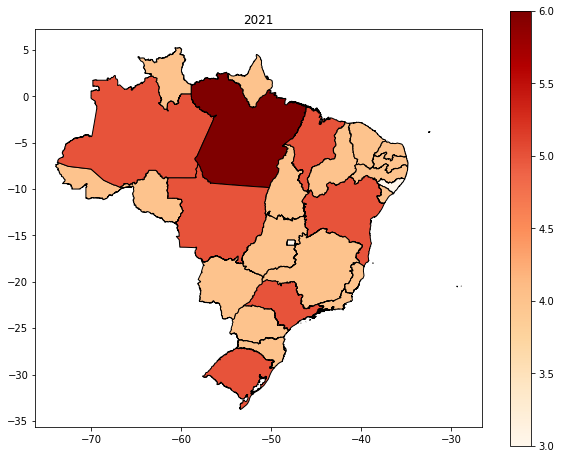

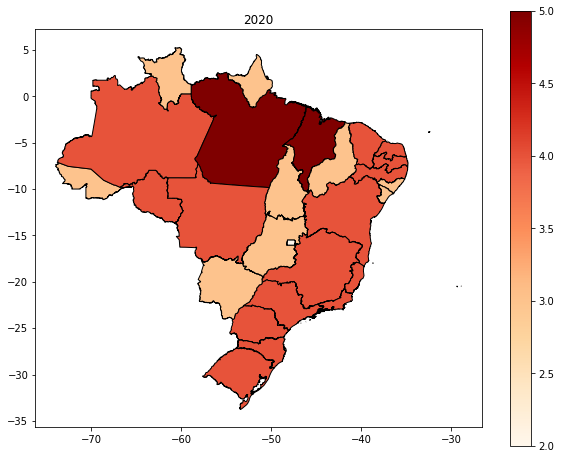

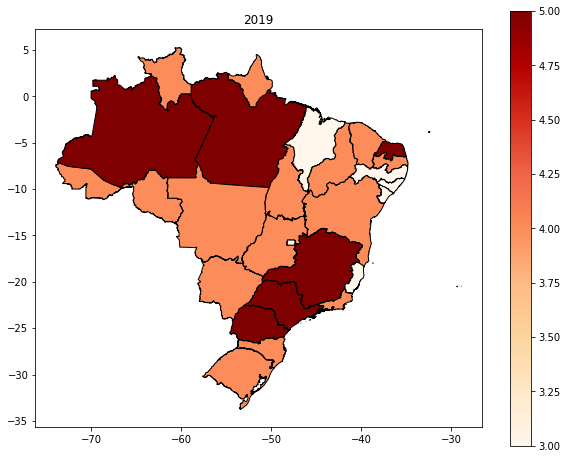

In [22]:
#@title Eccentricity
def plot_eccentricity(G, title):
    fig, ax = plt.subplots(1,1,figsize=(10,8))
    result = pd.DataFrame()
    for key, value in dict(nx.eccentricity(G)).items():
        result = result.append(pd.DataFrame({'Airport': [key], 'State': [G.nodes()[key]['AEROPORTO DE ORIGEM (UF)']], 'centrality': [value]}))
    result = result.sort_values(by='centrality').drop_duplicates(['State'], keep='last')

    states = ibge_data.merge(result, left_on = 'SIGLA_UF', right_on='State')
    states.plot(column = 'centrality',cmap='OrRd', edgecolor='k', legend=True, ax=ax)

    ax.set_title(title)

plot_eccentricity(BiggestStronglyConnectedGraph21, "2021")
plot_eccentricity(BiggestStronglyConnectedGraph20, "2020")
plot_eccentricity(BiggestStronglyConnectedGraph19, "2019")

In [23]:
#@title Diameter and periphery
def print_diameter(G, name):
    # the diameter of networks is the maximum eccentricy
    print(f"Diameter of {name}: {nx.diameter(G)}")

    # whom are in the diamter
    print(f'Periphery of {name}: {nx.periphery(G)}')

print_diameter(BiggestStronglyConnectedGraph21, "2021 data")
print_diameter(BiggestStronglyConnectedGraph20, "2020 data")
print_diameter(BiggestStronglyConnectedGraph19, "2019 data")

Diameter of 2021 data: 6
Periphery of 2021 data: ['SBTB', 'SNMA', 'SNOX', 'SNTI']
Diameter of 2020 data: 5
Periphery of 2020 data: ['SNRJ', 'SNMA', 'SNOX', 'SNTI']
Diameter of 2019 data: 5
Periphery of 2019 data: ['SBTT', 'SBTF', 'SBTD', 'SNGX', 'SNOS', 'SNUH', 'SNYA', 'SNAR', 'SNVC', 'SNDT', 'SNCT', 'SNJM', 'SSCT', 'SBMD', 'SSCP', 'SSFB', 'SSGY', 'SSKM', 'SSOG', 'SSPG', 'SSPI', 'SSUV', 'SSVL', 'SWMW', 'SBUA', 'SWBC', 'SWKO', 'SWCA', 'SWEI', 'SWLB']


In [24]:
#@title Radius and center
def print_radius(G, name):
    # the radius of networks is the minimum eccentricy
    print(f"Radius of {name}: {nx.radius(G)}")

    # whom are in the radius
    print(f'Center of {name}: {nx.center(G)}')

print_radius(BiggestStronglyConnectedGraph21, "2021 data")
print_radius(BiggestStronglyConnectedGraph20, "2020 data")
print_radius(BiggestStronglyConnectedGraph19, "2019 data")

Radius of 2021 data: 3
Center of 2021 data: ['SBCF', 'SBPJ', 'SBCG', 'SBSR', 'SBCT', 'SBKP', 'SBPV', 'SBRF', 'SBCY', 'SBRJ', 'SBGR', 'SBSP', 'SBDN', 'SBMO', 'SBCZ', 'SBGO', 'SBBR']
Radius of 2020 data: 2
Center of 2020 data: ['SBKP', 'SBBR']
Radius of 2019 data: 3
Center of 2019 data: ['SBCY', 'SBFZ', 'SBPS', 'SBSR', 'SBTE', 'SBBR', 'SBGO', 'SBPA', 'SBIL', 'SBRJ', 'SBSV', 'SBVT', 'SBRP', 'SBRF', 'SBBE', 'SBDN', 'SBCF', 'SBUF', 'SBKP', 'SBSL', 'SBJP', 'SBAR', 'SBMO', 'SBJU', 'SBFN', 'SBIZ', 'SBSG', 'SBQV', 'SBGL', 'SBUR', 'SBAX', 'SNTF', 'SBIP', 'SBAU', 'SBGV', 'SBUL', 'SBVG', 'SNBR', 'SBPL', 'SBLE', 'SBSP', 'SBGR']


## Node ranking

Let's check the importance of each node using Degree, Closeness, Betweenness and Eigenvector Centrality.

In [33]:
max(dict(nx.degree_centrality(GraphFlights21)).values())

0.9212598425196851

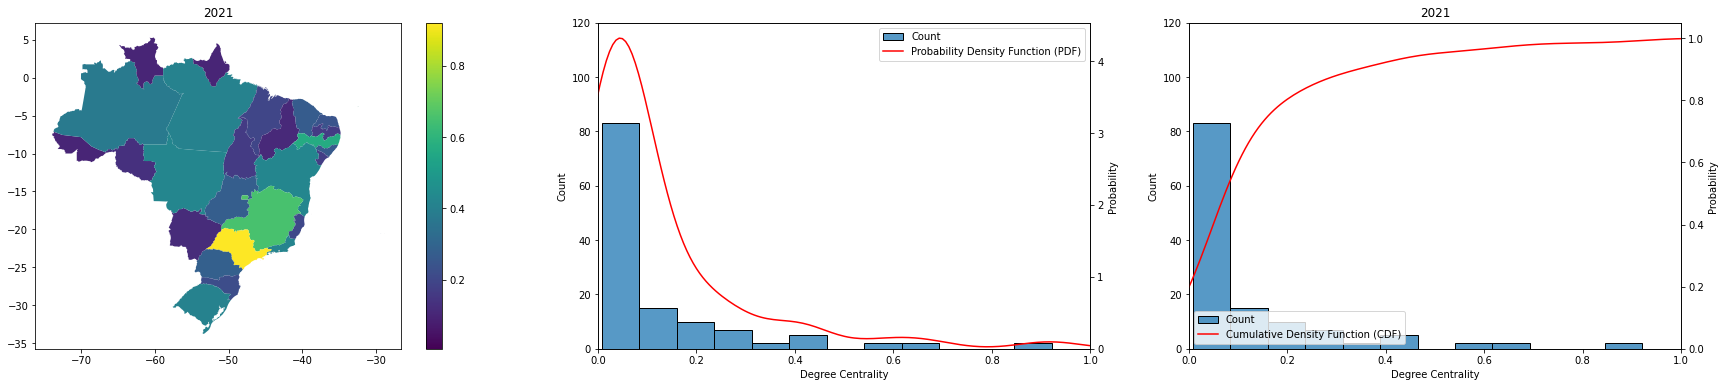

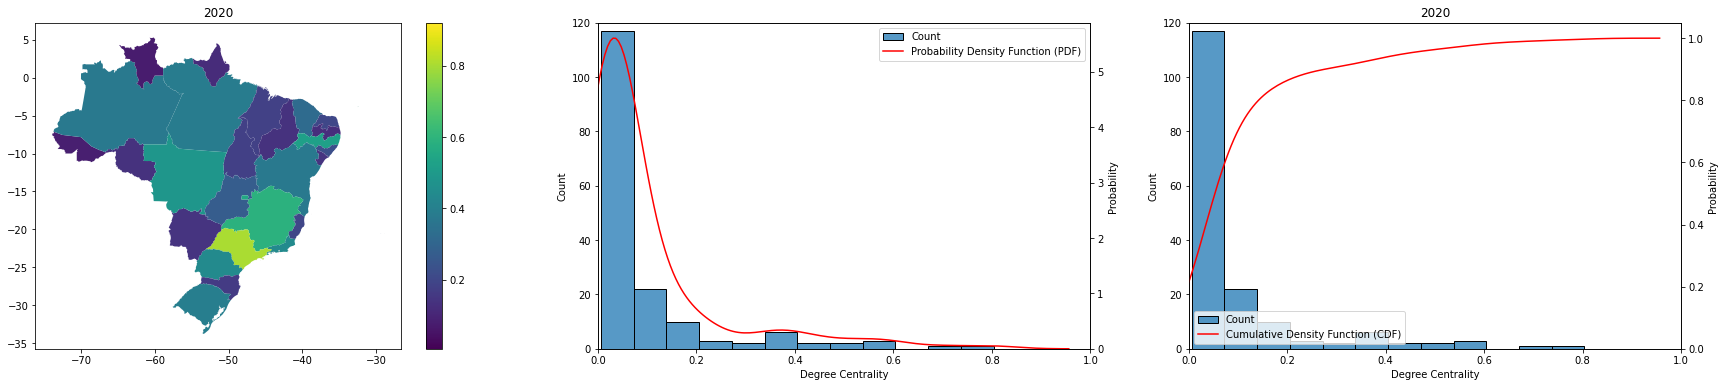

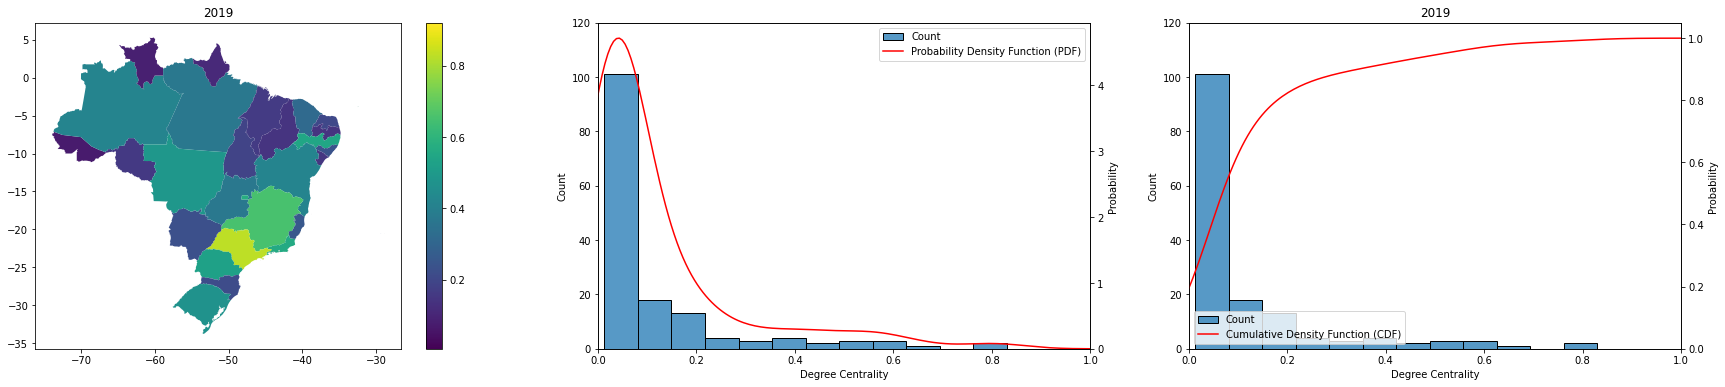

In [40]:
#@title Degree Centrality
mini = min([min(dict(nx.degree_centrality(GraphFlights21)).values()),
            min(dict(nx.degree_centrality(GraphFlights20)).values()),
            min(dict(nx.degree_centrality(GraphFlights19)).values())])
maxi = max([max(dict(nx.degree_centrality(GraphFlights21)).values()),
            max(dict(nx.degree_centrality(GraphFlights20)).values()),
            max(dict(nx.degree_centrality(GraphFlights19)).values())])

def plot_degree_crentrality(g, name):
    # the degree centrality of network(g)
    fig, (ax, ax_pdf, ax_cdf) = plt.subplots(1,3,figsize=(30,6))

    #
    # Plot Graph
    #
    result = pd.DataFrame()
    for key, value in dict(nx.degree_centrality(g)).items():
        result = result.append(pd.DataFrame({'Airport': [key], 'State': [g.nodes()[key]['AEROPORTO DE ORIGEM (UF)']], 'centrality': [value]}))
    result = result.sort_values(by='centrality').drop_duplicates(['State'], keep='last')

    states = ibge_data.merge(result, left_on = 'SIGLA_UF', right_on='State')
    states.plot(column = 'centrality', norm=colors.Normalize(vmin=mini, vmax=maxi), ax=ax)

    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mini, vmax=maxi)), ax=ax)
    ax.set_title(name)
    
    #
    # Plot PDF
    #
    degree_sequence = sorted(list(dict(nx.degree_centrality(g)).values()), reverse=True)
    sns.histplot(degree_sequence,bins=12,label="Count",ax=ax_pdf)
    ax2 = ax_pdf.twinx()
    sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

    lines, labels = ax_pdf.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax_pdf.grid(False)
    ax2.grid(False)
    ax_pdf.set_xlabel("Degree Centrality")
    ax2.set_ylabel("Probability")

    ax_pdf.set_xlim([0, 1])
    ax_pdf.set_ylim([0, 120])

    #
    # Plot CDF
    #
    sns.histplot(degree_sequence,bins=12,label="Count",ax=ax_cdf)
    ax3 = ax_cdf.twinx()
    sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax3,cumulative=True)

    lines, labels = ax_cdf.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax3.legend(lines + lines2, labels + labels2, loc=0)

    ax_cdf.grid(False)
    ax3.grid(False)
    ax_cdf.set_xlabel("Degree Centrality")
    ax3.set_ylabel("Probability")

    ax_cdf.set_xlim([0, 1])
    ax_cdf.set_ylim([0, 120])

    plt.savefig('degree_centrality.png', transparent=True,dpi=300)
    plt.title(name)
    plt.show()

plot_degree_crentrality(GraphFlights21, "2021")
plot_degree_crentrality(GraphFlights20, "2020")
plot_degree_crentrality(GraphFlights19, "2019")

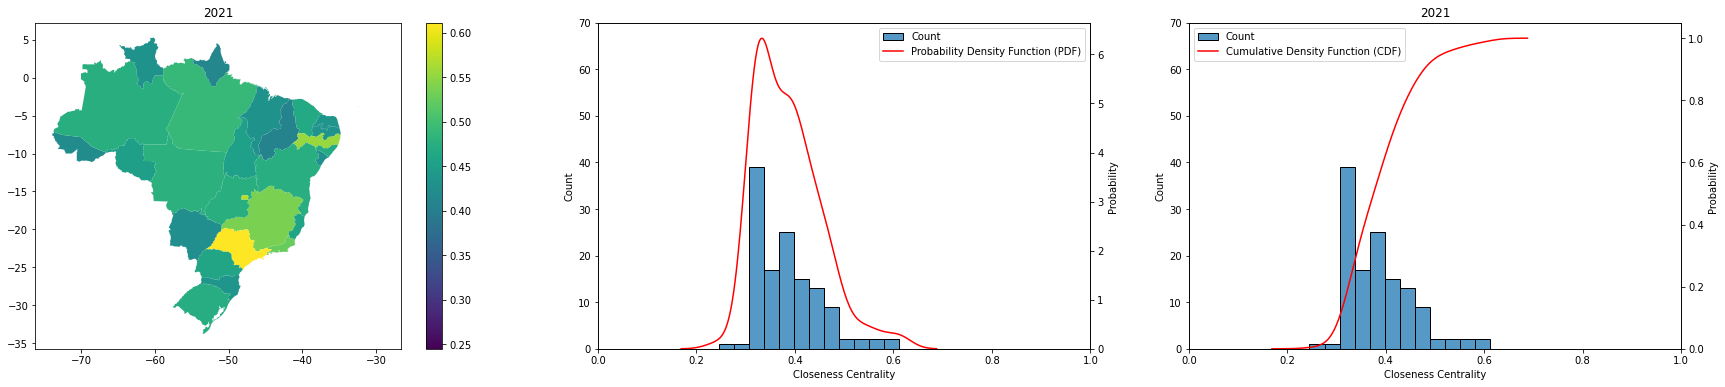

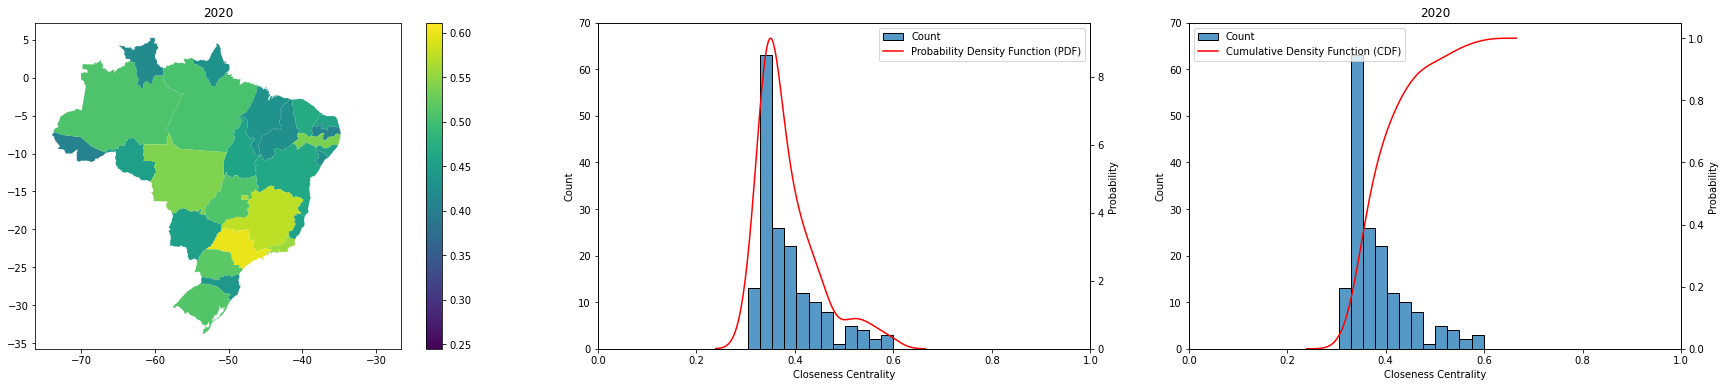

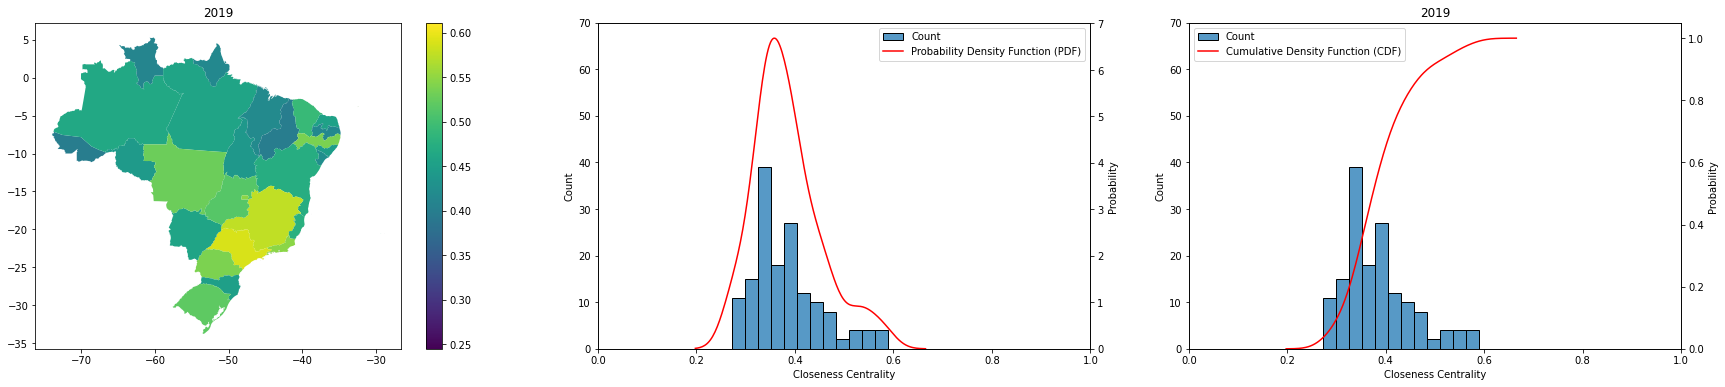

In [41]:
#@title Closeness Centrality
mini = min([min(dict(nx.closeness_centrality(GraphFlights21)).values()),
            min(dict(nx.closeness_centrality(GraphFlights20)).values()),
            min(dict(nx.closeness_centrality(GraphFlights19)).values())])
maxi = max([max(dict(nx.closeness_centrality(GraphFlights21)).values()),
            max(dict(nx.closeness_centrality(GraphFlights20)).values()),
            max(dict(nx.closeness_centrality(GraphFlights19)).values())])

def plot_closeness_crentrality(g, name):
    # the closeness centrality of network(g)
    fig, (ax, ax_pdf, ax_cdf) = plt.subplots(1,3,figsize=(30,6))

    #
    # Plot Graph
    #
    result = pd.DataFrame()
    for key, value in dict(nx.closeness_centrality(g)).items():
        result = result.append(pd.DataFrame({'Airport': [key], 'State': [g.nodes()[key]['AEROPORTO DE ORIGEM (UF)']], 'centrality': [value]}))
    result = result.sort_values(by='centrality').drop_duplicates(['State'], keep='last')

    states = ibge_data.merge(result, left_on = 'SIGLA_UF', right_on='State')
    states.plot(column = 'centrality', norm=colors.Normalize(vmin=mini, vmax=maxi), ax=ax)

    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mini, vmax=maxi)), ax=ax)
    ax.set_title(name)
    
    #
    # Plot PDF
    #
    closeness_sequence = sorted(list(dict(nx.closeness_centrality(g)).values()), reverse=True)
    sns.histplot(closeness_sequence,bins=12,label="Count",ax=ax_pdf)
    ax2 = ax_pdf.twinx()
    sns.kdeplot(closeness_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

    lines, labels = ax_pdf.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax_pdf.grid(False)
    ax2.grid(False)
    ax_pdf.set_xlabel("Closeness Centrality")
    ax2.set_ylabel("Probability")

    ax_pdf.set_xlim([0, 1])
    ax_pdf.set_ylim([0, 70])

    #
    # Plot CDF
    #
    sns.histplot(closeness_sequence,bins=12,label="Count",ax=ax_cdf)
    ax3 = ax_cdf.twinx()
    sns.kdeplot(closeness_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax3,cumulative=True)

    lines, labels = ax_cdf.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax3.legend(lines + lines2, labels + labels2, loc=0)

    ax_cdf.grid(False)
    ax3.grid(False)
    ax_cdf.set_xlabel("Closeness Centrality")
    ax3.set_ylabel("Probability")

    ax_cdf.set_xlim([0, 1])
    ax_cdf.set_ylim([0, 70])

    plt.savefig('Closeness_centrality.png', transparent=True,dpi=300)
    plt.title(name)
    plt.show()

plot_closeness_crentrality(GraphFlights21, "2021")
plot_closeness_crentrality(GraphFlights20, "2020")
plot_closeness_crentrality(GraphFlights19, "2019")

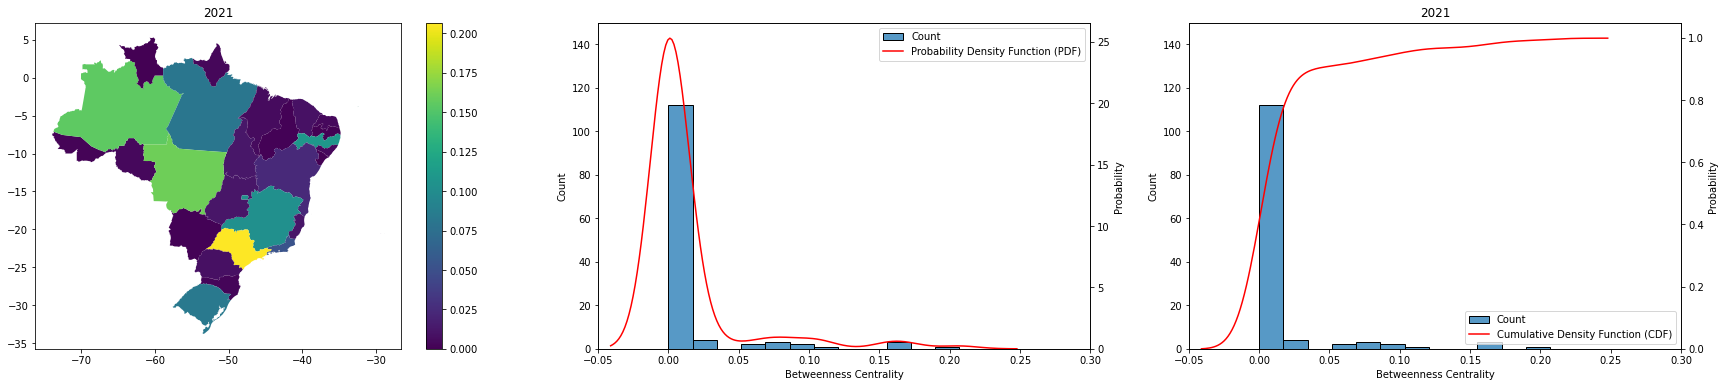

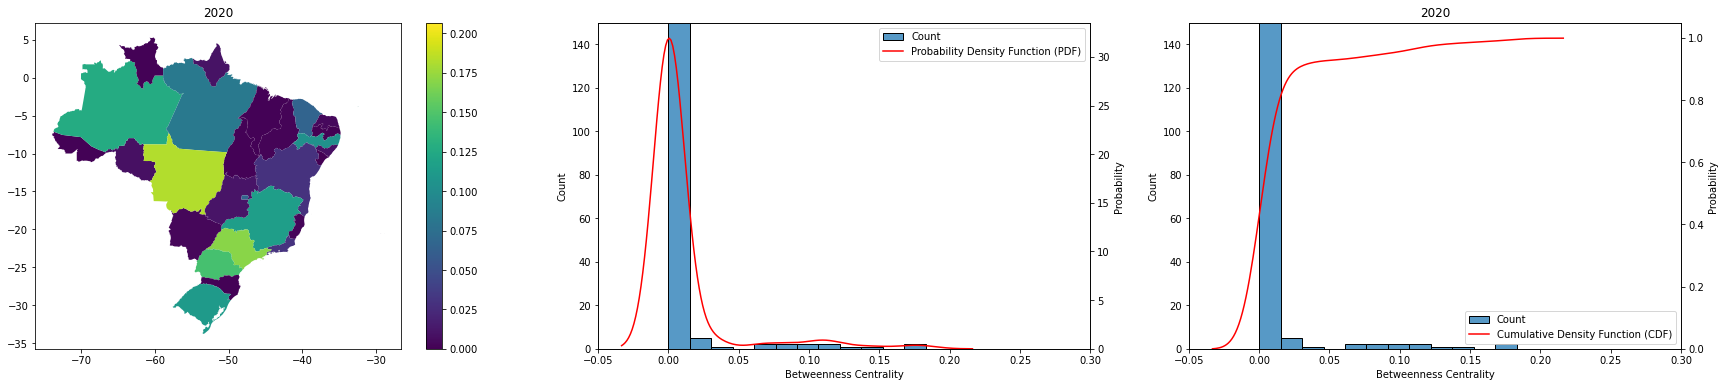

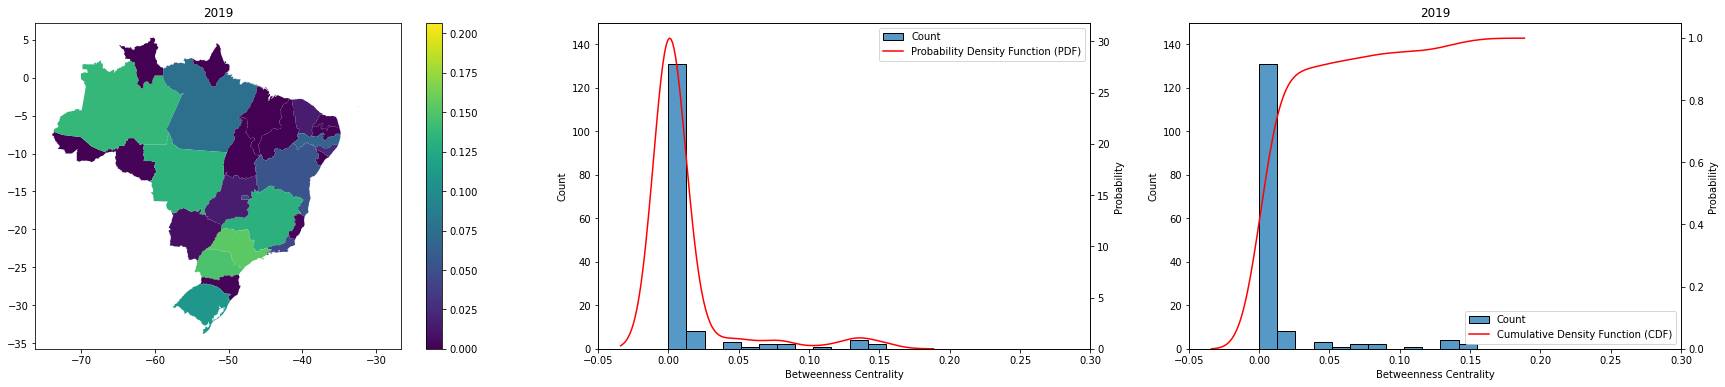

In [43]:
#@title Betweenness Centrality
mini = min([min(dict(nx.betweenness_centrality(GraphFlights21)).values()),
            min(dict(nx.betweenness_centrality(GraphFlights20)).values()),
            min(dict(nx.betweenness_centrality(GraphFlights19)).values())])
maxi = max([max(dict(nx.betweenness_centrality(GraphFlights21)).values()),
            max(dict(nx.betweenness_centrality(GraphFlights20)).values()),
            max(dict(nx.betweenness_centrality(GraphFlights19)).values())])

def plot_betweenness_crentrality(g, name):
    # the Betweenness centrality of network(g)
    fig, (ax, ax_pdf, ax_cdf) = plt.subplots(1,3,figsize=(30,6))

    #
    # Plot Graph
    #
    result = pd.DataFrame()
    for key, value in dict(nx.betweenness_centrality(g)).items():
        result = result.append(pd.DataFrame({'Airport': [key], 'State': [g.nodes()[key]['AEROPORTO DE ORIGEM (UF)']], 'centrality': [value]}))
    result = result.sort_values(by='centrality').drop_duplicates(['State'], keep='last')

    states = ibge_data.merge(result, left_on = 'SIGLA_UF', right_on='State')
    states.plot(column = 'centrality', norm=colors.Normalize(vmin=mini, vmax=maxi), ax=ax)

    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mini, vmax=maxi)), ax=ax)
    ax.set_title(name)
    
    #
    # Plot PDF
    #
    betweenness_sequence = sorted(list(dict(nx.betweenness_centrality(g)).values()), reverse=True)
    sns.histplot(betweenness_sequence,bins=12,label="Count",ax=ax_pdf)
    ax2 = ax_pdf.twinx()
    sns.kdeplot(betweenness_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

    lines, labels = ax_pdf.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax_pdf.grid(False)
    ax2.grid(False)
    ax_pdf.set_xlabel("Betweenness Centrality")
    ax2.set_ylabel("Probability")

    ax_pdf.set_xlim([-0.05, 0.30])
    ax_pdf.set_ylim([0, 150])

    #
    # Plot CDF
    #
    sns.histplot(betweenness_sequence,bins=12,label="Count",ax=ax_cdf)
    ax3 = ax_cdf.twinx()
    sns.kdeplot(betweenness_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax3,cumulative=True)

    lines, labels = ax_cdf.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax3.legend(lines + lines2, labels + labels2, loc=0)

    ax_cdf.grid(False)
    ax3.grid(False)
    ax_cdf.set_xlabel("Betweenness Centrality")
    ax3.set_ylabel("Probability")

    ax_cdf.set_xlim([-0.05, 0.30])
    ax_cdf.set_ylim([0, 150])

    plt.savefig('betweenness_centrality.png', transparent=True,dpi=300)
    plt.title(name)
    plt.show()

plot_betweenness_crentrality(GraphFlights21, "2021")
plot_betweenness_crentrality(GraphFlights20, "2020")
plot_betweenness_crentrality(GraphFlights19, "2019")

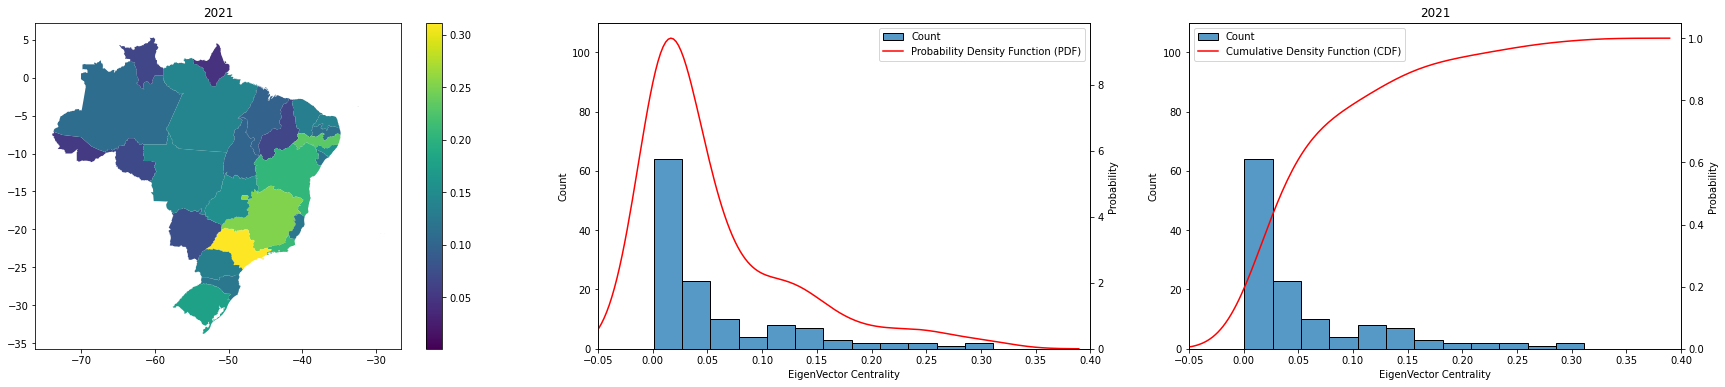

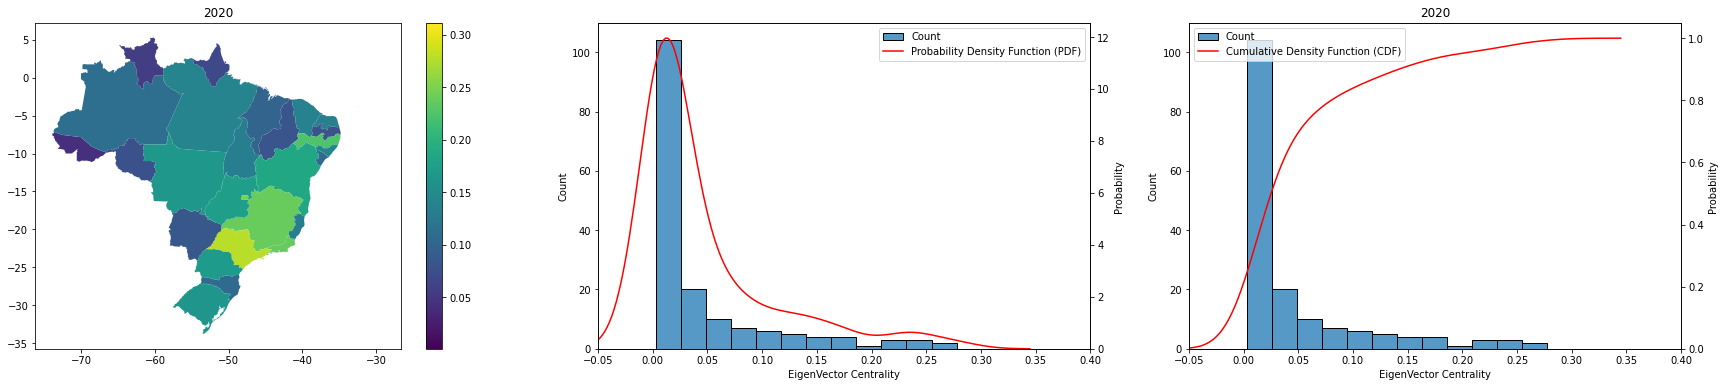

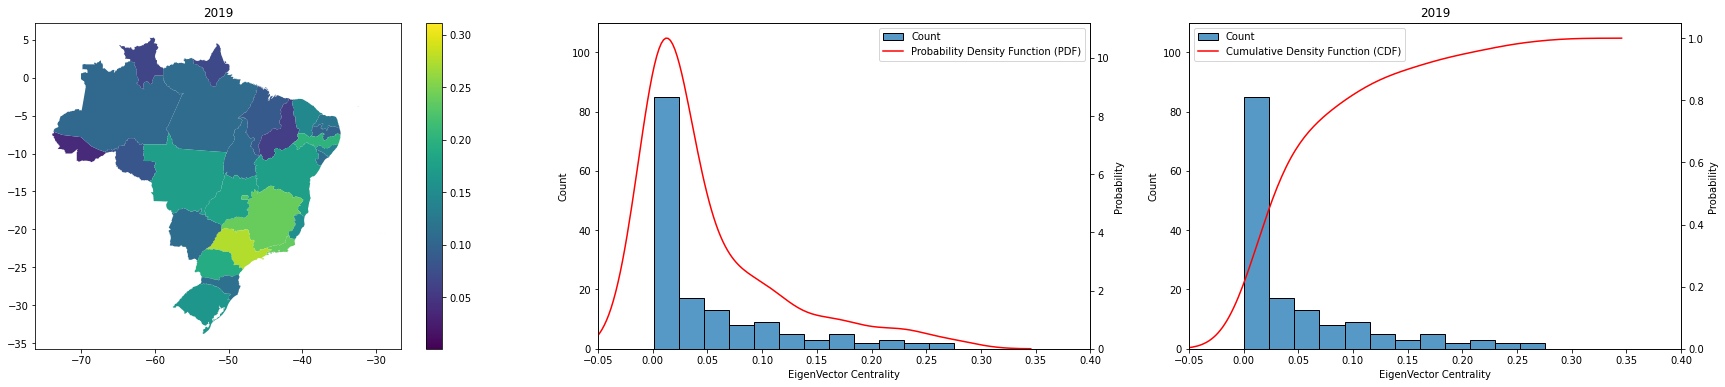

In [42]:
#@title EigenVector Centrality
mini = min([min(dict(nx.eigenvector_centrality(GraphFlights21)).values()),
            min(dict(nx.eigenvector_centrality(GraphFlights20)).values()),
            min(dict(nx.eigenvector_centrality(GraphFlights19)).values())])
maxi = max([max(dict(nx.eigenvector_centrality(GraphFlights21)).values()),
            max(dict(nx.eigenvector_centrality(GraphFlights20)).values()),
            max(dict(nx.eigenvector_centrality(GraphFlights19)).values())])

def plot_eigenvector_crentrality(g, name):
    # the eigenvector centrality of network(g)
    fig, (ax, ax_pdf, ax_cdf) = plt.subplots(1,3,figsize=(30,6))

    #
    # Plot Graph
    #
    result = pd.DataFrame()
    for key, value in dict(nx.eigenvector_centrality(g)).items():
        result = result.append(pd.DataFrame({'Airport': [key], 'State': [g.nodes()[key]['AEROPORTO DE ORIGEM (UF)']], 'centrality': [value]}))
    result = result.sort_values(by='centrality').drop_duplicates(['State'], keep='last')

    states = ibge_data.merge(result, left_on = 'SIGLA_UF', right_on='State')
    states.plot(column = 'centrality', norm=colors.Normalize(vmin=mini, vmax=maxi), ax=ax)

    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=mini, vmax=maxi)), ax=ax)
    ax.set_title(name)
    
    #
    # Plot PDF
    #
    eigenvector_sequence = sorted(list(dict(nx.eigenvector_centrality(g)).values()), reverse=True)
    sns.histplot(eigenvector_sequence,bins=12,label="Count",ax=ax_pdf)
    ax2 = ax_pdf.twinx()
    sns.kdeplot(eigenvector_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

    lines, labels = ax_pdf.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    ax_pdf.grid(False)
    ax2.grid(False)
    ax_pdf.set_xlabel("EigenVector Centrality")
    ax2.set_ylabel("Probability")

    ax_pdf.set_xlim([-0.05, 0.4])
    ax_pdf.set_ylim([0, 110])

    #
    # Plot CDF
    #
    sns.histplot(eigenvector_sequence,bins=12,label="Count",ax=ax_cdf)
    ax3 = ax_cdf.twinx()
    sns.kdeplot(eigenvector_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax3,cumulative=True)

    lines, labels = ax_cdf.get_legend_handles_labels()
    lines2, labels2 = ax3.get_legend_handles_labels()
    ax3.legend(lines + lines2, labels + labels2, loc=0)

    ax_cdf.grid(False)
    ax3.grid(False)
    ax_cdf.set_xlabel("EigenVector Centrality")
    ax3.set_ylabel("Probability")

    ax_cdf.set_xlim([-0.05, 0.4])
    ax_cdf.set_ylim([0, 110])

    plt.savefig('eigenvector_centrality.png', transparent=True,dpi=300)
    plt.title(name)
    plt.show()

plot_eigenvector_crentrality(GraphFlights21, "2021")
plot_eigenvector_crentrality(GraphFlights20, "2020")
plot_eigenvector_crentrality(GraphFlights19, "2019")